# Trabajo práctico 1 



**Human activity recognition**

https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/intro_ia/tree/cohorte-6/clase_2/jupyterbooks/data

**MNIST**

    from sklearn.datasets import fetch_openml
    X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)


Deben maximizarse la cantidad de operaciones vectorizadas en las implementaciones.


## Ejercicio 1 - Implementar clase PCA con numpy
**Dataset** Human activity recognition

Tomar las primeras 63 componentes principales y calcular la varianza contemplada. Realizar las operaciones internas con numpy.linalg. 

In [1]:
# importamos librerias

import numpy as np
from matplotlib import pyplot as plt
import os

# Importo sklearn solo para la normalización y centrado de los datos ya que no me funcionó lo que programé (da valores diferentes)
from sklearn.preprocessing import StandardScaler 

# evito los warnings (hay dos en los graficos de la clase PCA sobre el tipo de dato)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# implementación de la clase PCA

class pca(object):
    def __init__(self, dx, dy, cp):
        # Centramos y normalizamos los datos 
        #self.dx = (dx - np.mean(dx))/ np.std(dx)  # <==== Esto no da los mismos resultados que las siguientes dos lineas
        sc = StandardScaler()
        self.dx = sc.fit_transform(dx)
        
        self.dy = dy
        self.cp = cp
        
    def grafico_v_contemplada(self, vc):
        plt.figure(figsize=(10,7))
        plt.plot(np.cumsum(vc), color='k', lw=2)
        plt.xlabel('Cantidad de componentes')
        plt.ylabel('Total varianza contemplada')
        plt.xlim(0, 200)
        plt.ylim(0, 100)
        plt.yticks(np.arange(0, 100, 10))
        plt.axvline(self.cp, c='b')
        plt.axhline(90, c='r')
        plt.show();
        
    def grafico_componentes(self, d):   
        plt.figure(figsize=(12,10))
        plt.scatter(d[:, 0], d[:, 1], c=self.dy, alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', len(np.unique(self.dy))))
        plt.rcParams['axes.grid'] = False #Evita un warning
        plt.colorbar()
        plt.title('PCA projection 2D');
        
    def run(self):
        # calculo de la matriz de covarianza
        m_cov = np.cov(self.dx.T)
        # calculo de los autovalores y autovectores de la matriz covarianza
        a_valores, a_vectores = np.linalg.eig(m_cov)
        total_a_valores = sum(a_valores)
        v_contemplada = [((i/total_a_valores)*100) for i in sorted(a_valores, reverse=True)]
        self.grafico_v_contemplada(v_contemplada)
        # proyección
        p_matriz = (a_vectores.T[:][:self.cp]).T        
        x_pca = -self.dx.dot(p_matriz)
        # graficamos los primeros dos componentes
        self.grafico_componentes(x_pca)
        return x_pca

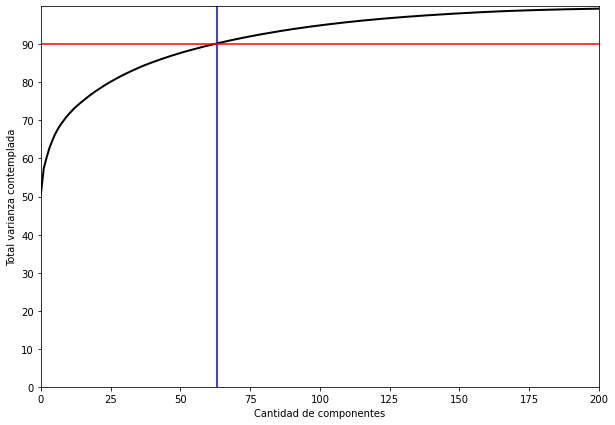

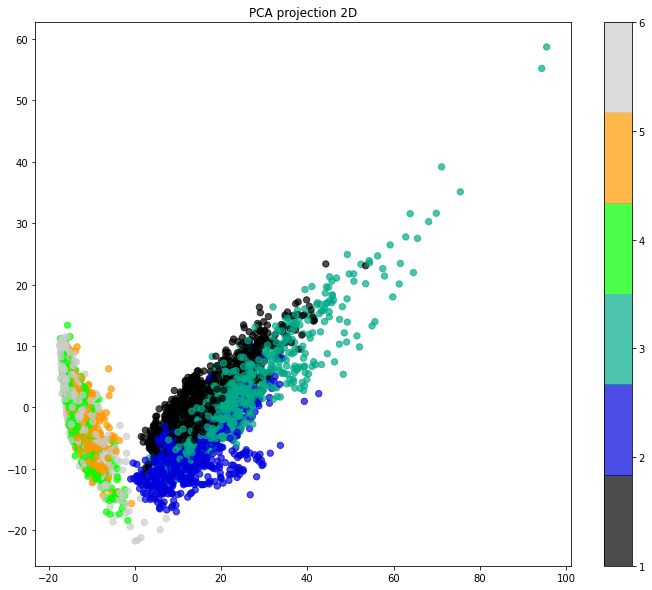

In [3]:
# cargo el dataset

path = "./UCI HAR Dataset/train"
x_train = np.loadtxt(os.path.join(path, "X_train.txt"))
y_train = np.loadtxt(os.path.join(path, "y_train.txt")).astype(int)

# aplico pca para 63 componentes principales

pca = pca(x_train, y_train, 63)
x_pca = pca.run()

## Ejercicio 2 - Implementar clase KMeans con numpy
**Dataset** Human activity recognition

Implementar kmeans con numpy. Agrupar el dataset transformado (ejercicio de PCA) y agrupar en clusters de k=2 y 6. Graficar los casos de k=2 y k=6 con las primeras dos componentes principales.

In [4]:
class kmeans(object):
    def __init__(self, n, d, i, ag):
        self.n = n            # cantidad de clusters n
        self.d = d.copy()     # dataset
        self.i = i            # cantidad de iteraciones
        self.ag = ag          # muestra los graficos de todas las iteraciones o no
        self.run()
        
    def centroides_init(self, datos, n):
        c = datos.copy()
        np.random.shuffle(c)
        return c[:n]
        
    def cercania(self, centroides):
        # se calcula la distancia entre todos los puntos en X y todos los puntos en C
        dist = np.sqrt(pow(  (self.d - centroides[:, np.newaxis]), 2).sum(axis=2))
        return np.argmin(dist, axis = 0)
    
    def mover_centroides(self, cercano, centroides):
        return np.array([self.d[cercano==k].mean(axis=0) for k in range(centroides.shape[0])])

    def distancia(self, d, centroide):
        dist=0
        for i in range(len(d)):
            dist+=pow((centroide[i] - d[i]),2)   
        return dist
    
    def asignar_puntos(self, d, centroides):
        dist_centroides = []
        for c in centroides:
            dist = self.distancia(d, c)
            dist_centroides.append(dist)
        centroide_cercano =  min(range(len(dist_centroides)), key=lambda d: dist_centroides[d])
        return centroide_cercano

    def grafico(self, indice, c, cluster):
        if ((self.ag) or (indice==self.i+1)):
            plt.subplot(self.i+1, 1, indice)  
            plt.scatter(self.d[:, 0], self.d[:, 1], c=cluster, alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', self.n))
            plt.scatter(c[:, 0], c[:, 1], c='r', s=20)
            plt.rcParams['axes.grid'] = False #Evita un warning
            plt.colorbar()
            plt.title('PCA projection 2D. Iteración: ' + str(indice-1));  

    def run(self):
        c = self.centroides_init(self.d, self.n)
        cluster = []
        for j in range(len(self.d)):
            cluster.append(self.asignar_puntos(self.d[j], c))   
        plt.figure(figsize=(12,10*self.i))
        self.grafico(1, c, cluster)
    
        for i in range(self.i):
            cercanos = self.cercania(c)
            c = self.mover_centroides(cercanos, c) 
            cluster = []
            for j in range(len(self.d)):
                cluster.append(self.asignar_puntos(self.d[j], c))   
            self.grafico(i+2, c, cluster)
            

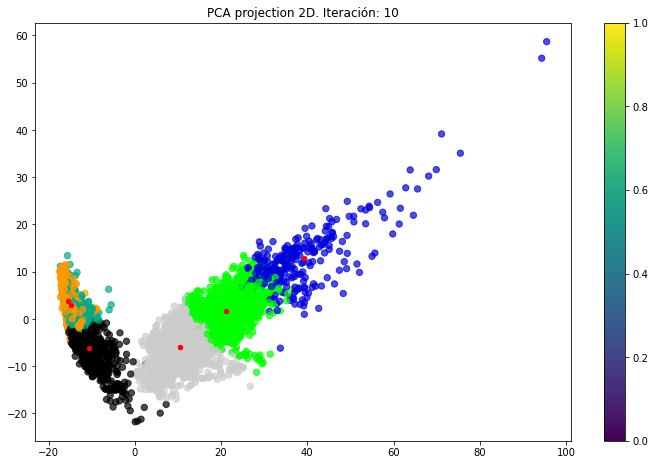

In [5]:
# Experimento con k=6 y 10 iteraciones
km = kmeans(6, x_pca, 10, False)

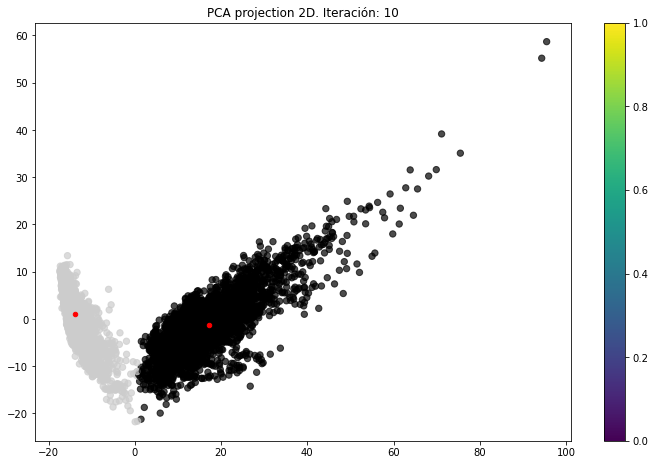

In [6]:
# Experimento con k=2 y 10 iteraciones
km = kmeans(2, x_pca, 10, False)

## Ejercicio 3 - Comparar los ejercicios anteriores con lo visto en las clases

En cuanto a los resultados, se observa que se puede llegar a lo mismo utilizando las librerias de sklearn que utilizando numpy. 

Con sklearn se reduce levemente el código que es necesario en el calculo de PCA. 

También noto una leve diferencia de velocidad a favor de lo programado con numpy pero habrá que experimentar más a fin de poder respaldar esta hipótesis.

Sin embargo, en la aplicación del método k-means utilizando las librerias de sklearn, se logra una simplificación y reducción muy notoria del código.

En mi caso, la aplicacion de los métodos utilizando numpy, y dado que es la primera vez que lo utilizo, no me da la misma confianza que utilizar sklearn. 

A modo de ejemplo de lo anterior, tuve que multiplicar por -1 en la linea 6 de "proyección" para obtener el mismo gráfico que en el notebook que utiliza sklearn. Probablemente sin tener este último notebook no habría podido obtener el mismo resultado. Aunque, lógicamente, lo imputo más a mi falta de práctica que a una imposibilidad técnica.

## Ejercicio 4 - PCA + KMeans

**Dataset**: MNIST

Con las implementaciones de sklearn, tomar las componentes principales que capturen el 90% de la varianza y aplicar kmeans para agrupar los dígitos en 10 clusters. Analizar los resultados. 

In [7]:
# Importamos librerias
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

In [8]:
# Cargamos los datos
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

In [9]:
RANDOM_STATE = 17

# Estandarizamos
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# Aplicamos PCA
pca = PCA(n_components=0.9, random_state=RANDOM_STATE).fit(X_sc)
X_pca = pca.transform(X_sc)

# Cantidad de componentes necesarios
X_pca.shape[1]   # = 238

238

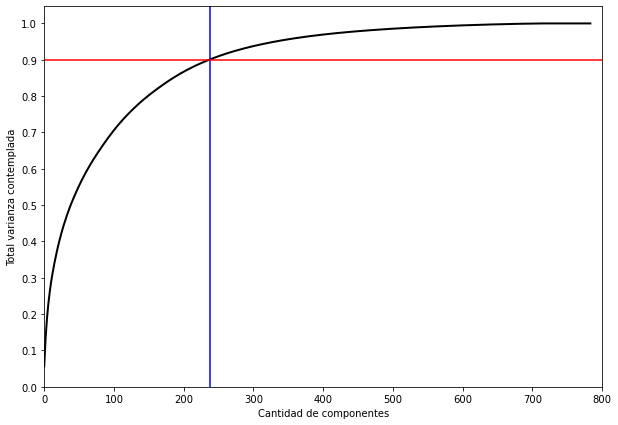

In [10]:
# Graficamos
pca_2 = PCA(n_components=784, random_state=RANDOM_STATE).fit(X_sc)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca_2.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Cantidad de componentes')
plt.ylabel('Total varianza contemplada')
plt.xlim(0, 800)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(238, c='b')
plt.axhline(0.9, c='r')
plt.show();

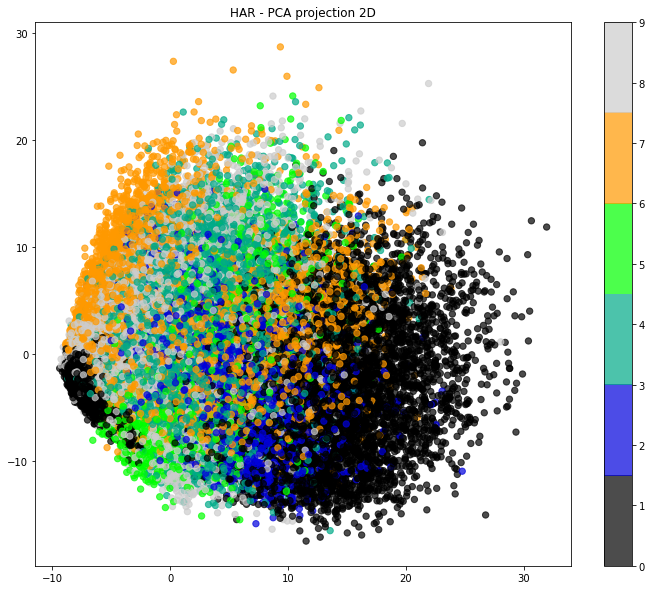

In [11]:
# Graficamos los primeros dos componentes
plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y.astype(int), alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 6))
plt.rcParams['axes.grid'] = False #Evita un warning
plt.colorbar()
plt.title('HAR - PCA projection 2D');

In [12]:
# Aplicamos Kmeans utilizando 10 clusters
kmeans = KMeans(n_clusters=10, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

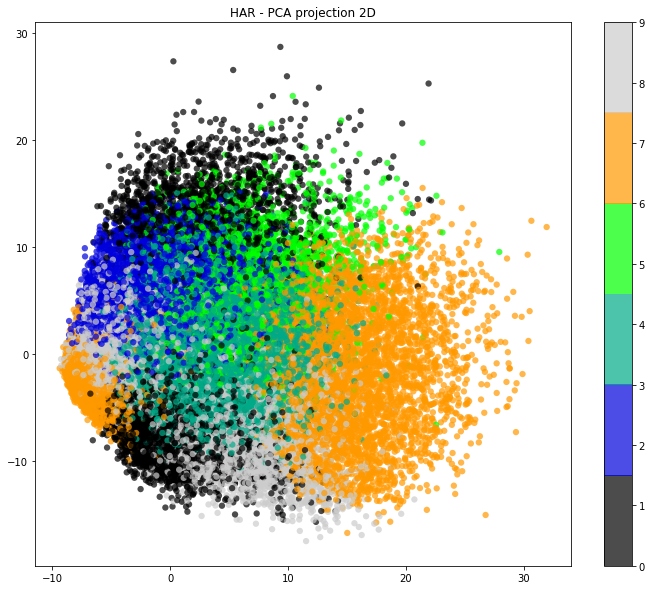

In [13]:
# Graficamos los primeros dos componentes - clusters id
plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 6))
plt.rcParams['axes.grid'] = False
plt.colorbar()
plt.title('HAR - PCA projection 2D');

In [14]:
# Analisis de resultados obtenidos
tab = pd.crosstab(y.astype(int), cluster_labels, margins=True)
tab.index = ['DIG '+ str(i) for i in range(10)] + ['Todos']
tab.columns = ['Cluster ' + str(i + 0) for i in range(10)] + ['Todos']
tab

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Todos
DIG 0,10,664,13,1322,358,116,35,3906,473,6,6903
DIG 1,1,159,7,28,16,13,7638,0,10,5,7877
DIG 2,40,85,190,731,849,2376,829,40,1820,30,6990
DIG 3,105,119,196,4110,88,727,575,11,1116,94,7141
DIG 4,343,944,3991,5,128,73,535,57,27,721,6824
DIG 5,64,2709,312,2134,102,243,467,33,159,90,6313
DIG 6,5,139,27,108,5316,425,560,283,12,1,6876
DIG 7,916,127,1610,10,3,15,523,20,13,4056,7293
DIG 8,73,2097,359,2595,31,197,1168,45,78,182,6825
DIG 9,431,127,3511,124,5,23,339,44,14,2340,6958


Se podría inferir que:

Dígito 0: Cluster 7 56,58 %, 
Dígito 1: Cluster 6 96,97 %, 
Dígito 2: Cluster 5 33,99 %, 
Dígito 3: Cluster 3 57,55 %, 
Dígito 4: Cluster 2 58,48 %, 
Dígito 5: Cluster 1 42,91 %, 
Dígito 6: Cluster 4 77,31 %, 
Dígito 7: Cluster 9 55,61 %, 
Dígito 8: Cluster 3 38,02 %, 
Dígito 9: Cluster 2 50,46 %.

De esta forma tenemos altas probabilidades de reconocer el número 1 y el número 6. Luego existe bastante confusión entre los clusters por lo concluyo que, con esta parametrización, no sería el mejor método para reconocimiento de los dígitos.